## Quiz 1: Understanding the Dataset

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os

%matplotlib inline

random.seed(42)

In [2]:
ab_data_file = os.path.join('./data', 'ab_data.csv')

df = pd.read_csv(ab_data_file)

df.sample(10)

,user_id,timestamp,group,landing_page,converted
39319,738882,2017-01-05 21:16:48.848974,control,old_page,0
129411,791559,2017-01-15 10:17:09.014354,treatment,new_page,0
25511,789443,2017-01-24 09:25:57.525883,control,old_page,1
1825,765129,2017-01-16 08:57:56.634990,control,old_page,1
173936,904720,2017-01-21 23:46:04.826708,control,old_page,0
76437,672006,2017-01-14 12:33:20.337536,control,old_page,0
142302,834772,2017-01-15 02:37:38.377770,treatment,new_page,0
29922,685787,2017-01-12 16:24:29.320036,treatment,new_page,0
88637,783255,2017-01-04 16:02:05.304335,treatment,new_page,0
268846,892133,2017-01-18 10:40:09.665205,control,old_page,0


In [3]:
'''
The number of rows in the dataset
'''

df.shape[0]

294478

In [4]:
'''
The number of unique users in the dataset
'''

df['user_id'].unique().shape[0]

290584

In [5]:
'''
The proportion of users converted
'''

df['converted'].mean()

0.11965919355605512

In [6]:
'''
The number of times the new_page and treatment don't match.
'''

gk = df.groupby('group')

control_group = gk.get_group('control')
treatment_group = gk.get_group('treatment')

num_new_page_n_control =  control_group[control_group['landing_page'] == 'new_page'].shape[0]
num_old_page_n_treatment =  treatment_group[treatment_group['landing_page'] == 'old_page'].shape[0]

num_new_page_n_control + num_old_page_n_treatment

3893

In [7]:
'''
Do any of the rows have missing values?
'''

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**Answer**: There is no missing values

---
## Quiz 2: Messy Data

In [8]:
'''
Drop rows satisfying the following conditions
- new_page & control
- old_page & treatment
'''

df2 = df.drop(control_group[control_group['landing_page'] == 'new_page'].index)

df2.drop(treatment_group[treatment_group['landing_page'] == 'old_page'].index, inplace=True)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

---
## Quiz 3: Updated Dataframe

In [10]:
'''
The number of unique users in df2
'''

df2['user_id'].unique().shape[0]

290584

In [11]:
'''
Row of non unique id
'''

duplicated_user = df2[df2['user_id'].duplicated()]

duplicated_user

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
df2.drop(duplicated_user.index, inplace=True)

---
## Quiz 4: Probability

In [13]:
'''
Probability of converting regardless of page
'''

df2['converted'].mean()

0.11959708724499628

In [14]:
'''
Given that an individual was in the control group, the probability of converting.
'''

df2.query("group == 'control'")['converted'].mean()

0.1203863045004612

In [15]:
'''
Given that an individual was in the treatment group, the probability of converting.
'''

df2.query("group == 'treatment'")['converted'].mean()

0.11880806551510564

In [16]:
'''
The probability of receiving the new page.
'''

df2_gk = df2.groupby('landing_page')

df2_gk.get_group('new_page').shape[0] / df2.shape[0]

0.5000619442226688

---
## Quiz 5: A/B Test

#### Hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**

* Null hypothesis: **$p_{old}$** >= **$p_{new}$**
* Alternative hypothesis: **$p_{old}$** < **$p_{new}$**

In [17]:
'''
p_new under the null
'''

p_new = df2['converted'].mean()

p_new

0.11959708724499628

In [18]:
'''
p_old under the null
'''

p_old = p_new

p_old

0.11959708724499628

In [19]:
'''
- n_new: the number of individuals in the treatment group
- n_old: the number of individuals in the control group
'''

gk = df2.groupby('group')

control_group = gk.get_group('control')
treatment_group = gk.get_group('treatment')

n_new = treatment_group.shape[0]
n_old = control_group.shape[0]

n_new, n_old

(145310, 145274)

In [20]:
'''
Simulate n_new transactions with a conversion rate of  p_new  under the null. 
Store these  n_new  1's and 0's in new_page_converted.
'''

new_page_converted = np.random.choice([0, 1], n_new, [1-p_new, p_new])

new_page_converted

array([1, 0, 1, ..., 1, 0, 1])

In [21]:
'''
Simulate n_old transactions with a convert rate of p_old under the null. 
Store these $n_{old}$ 1's and 0's in old_page_converted.
'''

old_page_converted = np.random.choice([0, 1], n_old, [1-p_old, p_old])

old_page_converted

array([0, 1, 0, ..., 1, 1, 1])

In [22]:
p_new = new_page_converted.mean()
p_old = old_page_converted.mean()

p_new - p_old

0.0011630682800014003

In [23]:
'''
Create 10,000  p_new  -  p_old values. Store all 10,000 values in a NumPy array called p_diffs
'''
p_diffs = []
n = 10000

for _ in range(n):
    
    new_page_converted = np.random.choice([0, 1], n_new, [1-p_new, p_new])
    old_page_converted = np.random.choice([0, 1], n_old, [1-p_old, p_old])
    
    p_new = new_page_converted.mean()
    p_old = old_page_converted.mean()

    p_diffs.append(p_new - p_old)
    
p_diffs = np.array(p_diffs)

Text(0.5, 1.0, 'Plot of 10,000 simulated p_diffs')

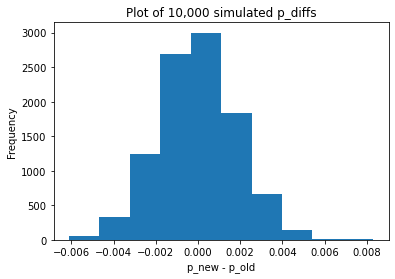

In [24]:
plt.hist(p_diffs)

plt.xlabel('p_new - p_old')
plt.ylabel('Frequency')
plt.title('Plot of 10,000 simulated p_diffs')

In [27]:
'''
What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv
'''

ab_data_file = os.path.join('./data', 'ab_data.csv')

df = pd.read_csv(ab_data_file)

lp_gk = df.groupby('landing_page')

actual_p_new = lp_gk.get_group('new_page')['converted'].mean()
actual_p_old = lp_gk.get_group('old_page')['converted'].mean()

actual_p_new, actual_p_old

(0.11884079625642663, 0.12047759085568362)

In [28]:
lp_gk = df2.groupby('landing_page')

actual_p_new = lp_gk.get_group('new_page')['converted'].mean()
actual_p_old = lp_gk.get_group('old_page')['converted'].mean()

actual_p_new, actual_p_old

(0.11880806551510564, 0.1203863045004612)